In [11]:
import pandas as pd
import math
from matplotlib import pyplot as plt
import time
import statistics
from tqdm import tqdm
import random

In [12]:
xg_df = pd.DataFrame(pd.read_pickle('dataset/intersection/statsbomb_matches_shots/shots_per_match.pkl')['shot_xgs'].sum())

In [13]:
# DP method
def assess_dp(p_is, repeat=30000):
    execution_times = []
    results = []
    for _ in range(repeat):
        execution_time = time.perf_counter_ns()
        # Initialize the dp table
        n = len(p_is)
        p_k = [1] + [0]*n
        # Iterate over the dp table
        for i in range(n+1):
            for c in range(i, 0, -1):
                inc = p_is[i-1]*p_k[c-1]
                p_k[c-1] -= inc
                p_k[c] += inc
        res = p_k
        execution_time = time.perf_counter_ns() - execution_time
        execution_times.append(execution_time)
        results.append(list(res))
    assert all([res == results[0] for res in results]), 'Results are not consistent'
    return res, statistics.mean(execution_times)

# FFT method
from poibin.poibin import PoiBin

def assess_fft(p_is, repeat=30000):
    execution_times = []
    results = []
    for _ in range(repeat):
        execution_time = time.perf_counter_ns()
        res = PoiBin(p_is).get_pmf_xi()
        execution_time = time.perf_counter_ns() - execution_time
        execution_times.append(execution_time)
        results.append(list(res))
    assert all([res == results[0] for res in results]), 'Results are not consistent'
    return res, statistics.mean(execution_times)

In [14]:
# DP method
def assess_one_dp(p_is):
    execution_time = time.perf_counter_ns()
    # Initialize the dp table
    n = len(p_is)
    p_k = [1] + [0]*n
    # Iterate over the dp table
    for i in range(n+1):
        for c in range(i, 0, -1):
            inc = p_is[i-1]*p_k[c-1]
            p_k[c-1] -= inc
            p_k[c] += inc
    res = p_k
    execution_time = time.perf_counter_ns() - execution_time
    return res, execution_time

# FFT method
from poibin.poibin import PoiBin

def assess_one_fft(p_is):
    execution_time = time.perf_counter_ns()
    res = PoiBin(p_is).get_pmf_xi()
    execution_time = time.perf_counter_ns() - execution_time
    return res, execution_time

0/180000 runs completed
18000/180000 runs completed
36000/180000 runs completed
54000/180000 runs completed
72000/180000 runs completed
90000/180000 runs completed
108000/180000 runs completed
126000/180000 runs completed
144000/180000 runs completed
162000/180000 runs completed


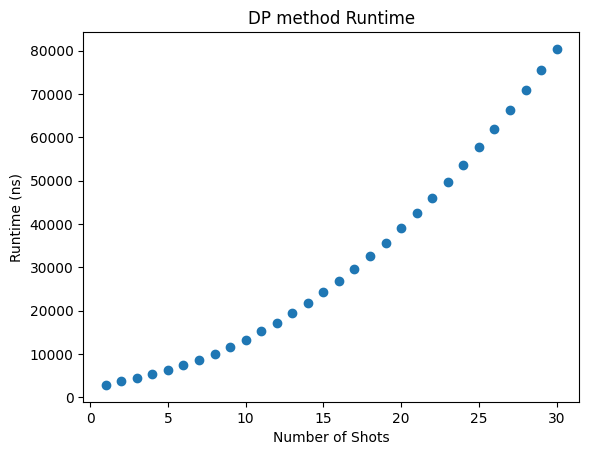

In [15]:
N = 30
RERUNS = 6000
dp_times, fft_times = {i: [] for i in range(1, N+1)}, {i: [] for i in range(1, N+1)}
total_runs = RERUNS*N
loopcount = 0

while any([len(dp_times[i]) < RERUNS for i in range(1, N+1)]):
    length = random.randint(1, N)
    if len(dp_times[length]) == RERUNS:
        continue
    p_is = xg_df.sample(length, replace=True).values.flatten().tolist()
    dp_times[length].append(assess_one_dp(p_is)[1])
    fft_times[length].append(assess_one_fft(p_is)[1])
    if loopcount % (total_runs//10) == 0:
        print(f'{loopcount}/{total_runs} runs completed')
    loopcount += 1

dp_times = [statistics.median(dp_times[i]) for i in range(1, N+1)]
fft_times = [statistics.median(fft_times[i]) for i in range(1, N+1)]
    
plt.scatter(range(1, N+1), dp_times)
plt.title('DP method Runtime')
plt.xlabel('Number of Shots')
plt.ylabel('Runtime (ns)')
plt.show()

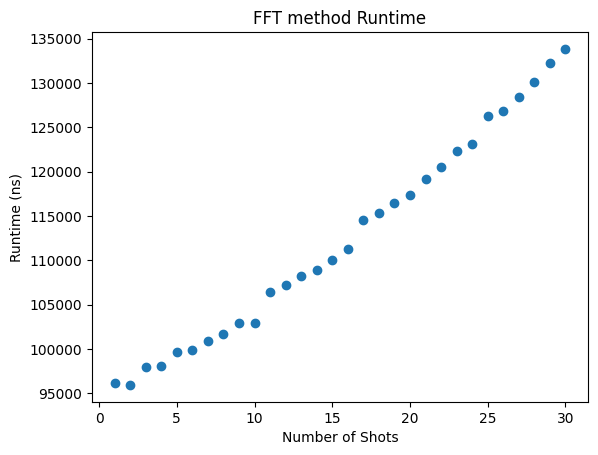

In [16]:
plt.clf()
plt.scatter(range(1, N+1), fft_times)
plt.title('FFT method Runtime')
plt.xlabel('Number of Shots')
plt.ylabel('Runtime (ns)')
plt.show()

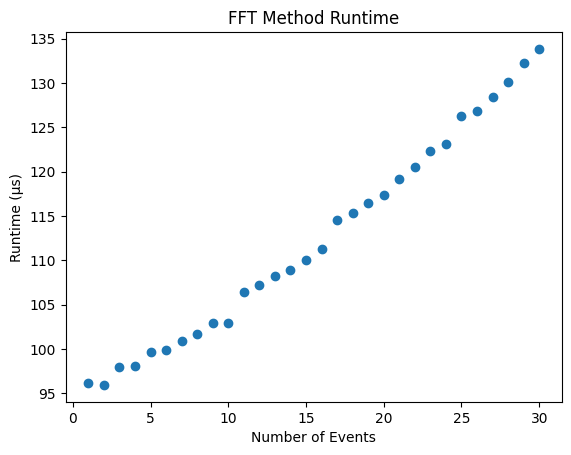

In [17]:
fft_times = [x/1000 for x in fft_times]
dp_times = [x/1000 for x in dp_times]
plt.clf()
plt.scatter(range(1, N+1), fft_times)
plt.title('FFT Method Runtime')
plt.xlabel('Number of Events')
plt.ylabel('Runtime (μs)')
plt.show()

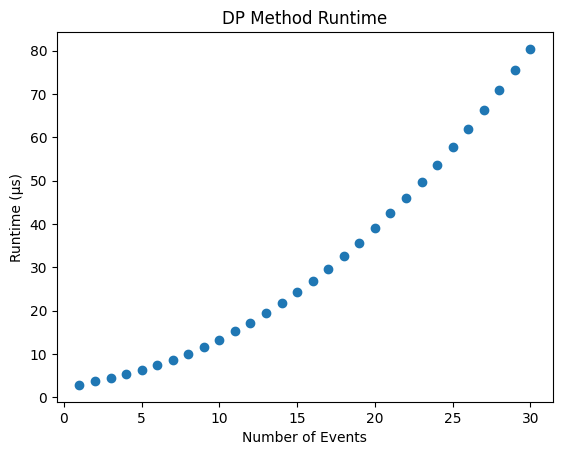

In [18]:
plt.clf()
plt.scatter(range(1, N+1), dp_times)
plt.title('DP Method Runtime')
plt.xlabel('Number of Events')
plt.ylabel('Runtime (μs)')
plt.show()

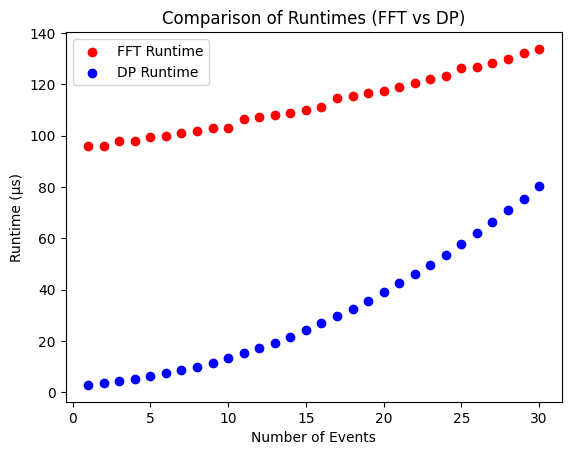

In [22]:
plt.clf()
sample_sizes = range(1, N+1)
plt.scatter(sample_sizes, fft_times, c='red', label='FFT Runtime')
plt.scatter(sample_sizes, dp_times, c='blue', label='DP Runtime')
plt.title('Comparison of Runtimes (FFT vs DP)')
plt.xlabel('Number of Events')
plt.ylabel('Runtime (μs)')
plt.legend()
plt.show()